In [1]:
# DATA

import pandas as pd
import stan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# stan problems
import nest_asyncio
nest_asyncio.apply()

data = pd.read_csv("sample_response_times.csv", sep=';')

data.head()

,rt,choice,condition
0,0.477,1.0,1.0
1,0.600,1.0,1.0
2,0.500,0.0,1.0
3,0.416,1.0,1.0
4,0.435,1.0,1.0


In [2]:
stan_code = """
data {
    int<lower=1> N;
    array[N] real<lower=0> y;
    array[N] int<lower=1, upper=2> condition;
    array[N] int<lower=0, upper=1> choice;
}

// EVERYTHING ABOVE 0!!!! EVERYTHING!!!!!!
parameters {
    real<lower=0> v_easy;         // Drift rate for easy condition
    real<lower=0> v_hard;         // Drift rate for hard condition
    real<lower=0> a;              // Boundary separation
    real<lower=0, upper=1> beta;  // Starting point bias
    real<lower=0, upper=min(y)> tau;  // Non-decision time with upper bound
}

model {
    // Priors (updated)
    v_easy ~ gamma(1, 2);
    v_hard ~ gamma(1, 2);
    a ~ gamma(2, 0.5);
    beta ~ beta(2, 2);
    tau ~ gamma(1, 10);

    // Likelihood (unchanged)
    for (n in 1:N) {
        if (condition[n] == 1) {
            if (choice[n] == 1) {
                y[n] ~ wiener(a, tau, beta, v_easy);
            } else {
                y[n] ~ wiener(a, tau, 1 - beta, -v_easy);
            }
        }
        if (condition[n] == 2) {
            if (choice[n] == 1) {
                y[n] ~ wiener(a, tau, beta, v_hard);
            } else {
                y[n] ~ wiener(a, tau, 1 - beta, -v_hard);
            }
        }
    }
}
"""

In [3]:
stan_data = {
    "N": len(data),
    "y": data["rt"].astype(float).values,
    "condition": data["condition"].astype(int).values,
    "choice": data["choice"].astype(int).values
}

model = stan.build(program_code=stan_code, data=stan_data)
fit = model.sample(num_chains=4, num_samples=2000)

# Diagnostics
print(fit)  # R-hat and EES

Building...

In file included from /home/ion606/Desktop/Homework/COGMOD/HW3/COGMOD-HWI/HW3/.venv/lib/python3.12/site-packages/httpstan/include/tbb/tbb_profiling.h:123,
                 from /home/ion606/Desktop/Homework/COGMOD/HW3/COGMOD-HWI/HW3/.venv/lib/python3.12/site-packages/httpstan/include/tbb/task.h:36,
                 from /home/ion606/Desktop/Homework/COGMOD/HW3/COGMOD-HWI/HW3/.venv/lib/python3.12/site-packages/httpstan/include/tbb/task_arena.h:23,
                 from /home/ion606/Desktop/Homework/COGMOD/HW3/COGMOD-HWI/HW3/.venv/lib/python3.12/site-packages/httpstan/include/stan/math/prim/core/init_threadpool_tbb.hpp:18,
                 from /home/ion606/Desktop/Homework/COGMOD/HW3/COGMOD-HWI/HW3/.venv/lib/python3.12/site-packages/httpstan/include/stan/math/prim/core.hpp:4,
                 from /home/ion606/Desktop/Homework/COGMOD/HW3/COGMOD-HWI/HW3/.venv/lib/python3.12/site-packages/httpstan/include/stan/math/rev/core/Eigen_NumTraits.hpp:5,
                 from /home/ion606/Desktop


Building: 30.6s, done.Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (401/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  28% (3300/12000)
Sam

<stan.Fit>
Parameters:
    v_easy: ()
    v_hard: ()
    a: ()
    beta: ()
    tau: ()
Draws: 8000


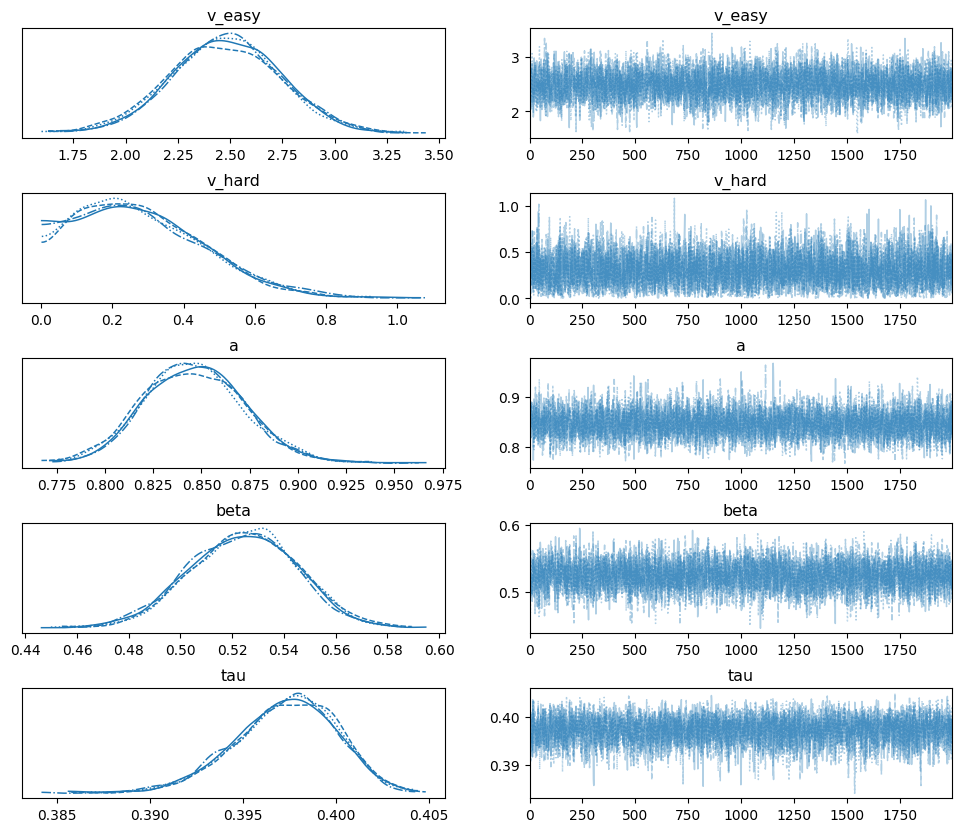

v_easy: mean = 2.48, 95% HDI = [1.95654057 2.98963516]
v_hard: mean = 0.28, 95% HDI = [0.01961169 0.67641368]


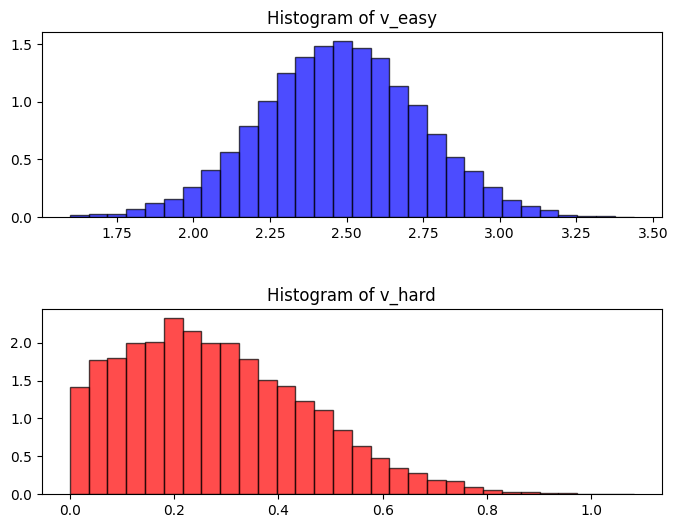

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_easy,2.478,0.262,1.986,2.972,0.004,0.003,4630.0,4592.0,1.0
v_hard,0.282,0.177,0.000,0.582,0.003,0.002,3177.0,2269.0,1.0
a,0.846,0.026,0.799,0.896,0.000,0.000,4537.0,4743.0,1.0
beta,0.524,0.021,0.484,0.561,0.000,0.000,4227.0,4836.0,1.0
tau,0.397,0.003,0.392,0.402,0.000,0.000,4290.0,5254.0,1.0


In [4]:
# print and graph in a different cell because the stan takes 5 to 10 business centuries to run

v_easy = fit["v_easy"]
v_hard = fit["v_hard"]
a = fit["a"]
beta = fit["beta"]
tau = fit["tau"]

fig = az.plot_trace(fit)
plt.subplots_adjust(hspace=0.5)
plt.savefig('trace_plot.png')
plt.show()

print(
    f"v_easy: mean = {np.mean(v_easy):.2f}, 95% HDI = {np.percentile(v_easy, [2.5, 97.5])}")
print(
    f"v_hard: mean = {np.mean(v_hard):.2f}, 95% HDI = {np.percentile(v_hard, [2.5, 97.5])}")


fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 2 subplots
axes[0].hist(v_easy.flatten(), bins=30, density=True,
             alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title("Histogram of v_easy")

axes[1].hist(v_hard.flatten(), bins=30, density=True,
             alpha=0.7, color='red', edgecolor='black')
axes[1].set_title("Histogram of v_hard")

plt.subplots_adjust(hspace=0.5)
plt.savefig("drift_rate_histograms.png", bbox_inches='tight')
plt.show()

az.summary(fit)